In [1]:
import os
import sys
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from sklearn.decomposition import PCA
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

28-Sep-22 14:25:36 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


In [2]:
config = general.load_config_file("/allen/aics/assay-dev/MicroscopyOtherData/Viana/datasets/variance/")

In [3]:
config["project"]["local_staging"] = "/allen/aics/assay-dev/MicroscopyOtherData/Viana/datasets/variance/"

In [4]:
control = controller.Controller(config)
device = io.LocalStagingIO(control)

In [5]:
df = device.load_step_manifest("preprocessing")

In [6]:
space = shapespace.ShapeSpace(control)
space.execute(df)

In [7]:
# space.set_active_shape_mode("NUC_MEM_PC1", digitize=True)
# mpId = control.get_center_map_point_index()
# space.set_active_map_point_index(mpId)
# CellIds = space.get_active_cellids()

In [8]:
space.set_active_shape_mode("NUC_MEM_PC1", digitize=True)
df_withbins = df.join(space.meta[space.meta["mpId"] == control.get_center_map_point_index()]["mpId"])
df_withbins = df_withbins[df_withbins["mpId"].notna()]

In [9]:
SEED = 24
sampled_strucs = []
for _, data in df_withbins.groupby(["structure_name"]):
    sampled_struc_data = data.sample(32, random_state=SEED)
    sampled_strucs.append(sampled_struc_data)
df_subset = pd.concat(sampled_strucs)

In [10]:
df_subset["structure_name"].value_counts()

AAVS1        32
NPM1         32
TOMM20       32
TJP1         32
ST6GAL1      32
SON          32
SMC1A        32
SLC25A17     32
SEC61B       32
RAB5A        32
PXN          32
NUP153       32
MYH10        32
ACTB         32
LMNB1        32
LAMP1        32
HIST1H2BJ    32
GJA1         32
FBL          32
DSP          32
CTNNB1       32
CETN2        32
ATP2A2       32
ACTN1        32
TUBA1B       32
Name: structure_name, dtype: int64

In [29]:
structures = df_subset["structure_name"].unique()

In [30]:
producer = io.DataProducer(control)
for struc in structures: 
    struc_subset_df = df_subset[df_subset["structure_name"] == struc]

    for _,r in struc_subset_df.iterrows():
        producer.set_row(r)
        producer.load_single_cell_data()
        producer.align_data()
        nuc = (producer.data_aligned[3]>0).astype(np.uint8)
        mem = (producer.data_aligned[4]>0).astype(np.uint8)
        instance = np.stack([nuc, mem, producer.data_aligned[2], producer.data_aligned[-1]], axis=0).astype(np.uint16)

        niso = control.get_number_of_interpolating_points()
        coords_param, coeffs_centroid = cytoparam.parameterize_image_coordinates(
            seg_mem=mem,
            seg_nuc=nuc,
            lmax=control.get_lmax(),
            nisos=[niso, niso]
        )

        coeffs_mem, centroid_mem, coeffs_nuc, centroid_nuc = coeffs_centroid

        rep = cytoparam.parameterization_from_shcoeffs(
            coeffs_mem=coeffs_mem,
            centroid_mem=centroid_mem,
            coeffs_nuc=coeffs_nuc,
            centroid_nuc=centroid_nuc,
            nisos=[niso, niso],
            images_to_probe=[("gfp", instance[-2]), ("seg", instance[-1])]
        ).data.squeeze()

        morphed_gfp = cytoparam.morph_representation_on_shape(
            img=nuc+mem,
            param_img_coords=coords_param,
            representation=rep[0]
        )

        morphed_seg = cytoparam.morph_representation_on_shape(
            img=nuc+mem,
            param_img_coords=coords_param,
            representation=rep[1]
        )
        instance_rec = np.stack([nuc, mem, morphed_gfp, morphed_seg], axis=0).astype(np.uint16)
        valids = np.where(mem)
        raw_corr = np.corrcoef(instance[-2][valids], instance_rec[-2][valids])[0,1]
        seg_corr = np.corrcoef(instance[-1][valids], instance_rec[-1][valids])[0,1]
        df_subset.loc[_, "raw_pilr_recon_corr"] = raw_corr
        df_subset.loc[_, "seg_pilr_recon_corr"] = seg_corr

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 15:48:50 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 15:51:57 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 15:55:52 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 15:59:09 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 16:02:43 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 16:05:50 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 16:09:43 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 16:13:04 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 16:16:23 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 16:19:45 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 16:23:20 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 16:26:49 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 16:30:14 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 16:33:32 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 16:37:21 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 16:40:24 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 16:43:43 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 16:46:45 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 16:50:30 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 16:53:58 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 16:57:21 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 17:01:19 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 17:04:40 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 17:08:46 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 17:12:39 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 17:16:52 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 17:20:02 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 17:23:34 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 17:26:43 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/allen/aics/apps/hpc_shared/mod/a

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 17:30:15 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 17:33:51 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 17:37:30 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 17:41:28 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 17:45:12 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 17:49:00 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 17:52:28 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 17:55:59 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 17:59:22 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 18:02:54 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 18:06:07 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 18:09:50 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 18:13:15 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 18:16:47 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 18:20:00 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 18:23:45 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 18:26:38 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 18:30:41 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 18:33:44 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 18:37:33 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 18:41:17 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 18:44:48 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 18:48:11 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 18:51:48 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 18:55:15 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 18:58:59 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 19:02:13 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 19:05:39 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 19:08:53 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 19:12:12 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 19:15:40 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 19:19:11 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 19:22:20 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 19:25:49 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 19:29:25 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 19:33:16 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/a

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 19:36:43 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 19:40:01 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 19:43:39 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 19:46:54 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 19:50:38 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 19:53:59 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

28-Sep-22 19:57:17 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 19:57:48 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into t

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:01:26 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:05:18 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:08:28 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:11:29 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:14:15 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:17:47 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:20:48 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:24:05 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:27:23 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:30:56 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:34:31 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:38:36 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:41:51 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:45:33 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:48:34 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:52:33 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:55:43 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 20:59:41 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 21:02:52 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 21:06:05 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 21:09:19 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 21:12:42 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 21:16:16 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 21:20:06 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 21:23:02 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 21:26:27 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 21:29:48 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 21:33:20 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 21:36:24 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 21:40:09 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
28-Sep-22 21:43:19 - bfio.backends.PythonReader - WARNING  - read_metadata(): OME XML required reformatting.
/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, va

In [31]:
df_subset

,roi,crop_raw,crop_seg,name_dict,fov_path,fov_seg_path,struct_seg_path,structure_name,this_cell_nbr_complete,this_cell_nbr_dist_2d,...,RAWSTR_MASKEDBY_MEM_intensity_min,RAWSTR_MASKEDBY_MEM_intensity_mean_lcc,RAWSTR_MASKEDBY_MEM_intensity_std_lcc,RAWSTR_MASKEDBY_MEM_intensity_1pct_lcc,RAWSTR_MASKEDBY_MEM_intensity_99pct_lcc,RAWSTR_MASKEDBY_MEM_intensity_max_lcc,RAWSTR_MASKEDBY_MEM_intensity_min_lcc,mpId,raw_pilr_recon_corr,seg_pilr_recon_corr
CellId,,,,,,,,,,,,,,,,,,,,,
973444,"[41, 138, 139, 442, 152, 384]",/allen/aics/assay-dev/MicroscopyOtherData/Vian...,/allen/aics/assay-dev/MicroscopyOtherData/Vian...,"{'crop_raw': ['dna', 'membrane', 'structure'],...",fov_path/21e5a55d667f6bee03e05c84ba2422556fce9...,fov_seg_path/924f2161caf6dc3c6c3f624a0b38a4019...,struct_seg_path/f65cd38960344934ea5efe372d60f8...,AAVS1,0,"[(973442, 137.7312689926826), (973452, 151.248...",...,410.0,635.011827,165.973483,475.0,1263.0,2167.0,410.0,5.0,0.952962,0.729683
611530,"[27, 132, 0, 238, 209, 499]",/allen/aics/assay-dev/MicroscopyOtherData/Vian...,/allen/aics/assay-dev/MicroscopyOtherData/Vian...,"{'crop_raw': ['dna', 'membrane', 'structure'],...",fov_path/b5309f481ab3921908ac058c06df8b67898a3...,fov_seg_path/15b235ccebafaa828846a44b90eb8c6b4...,struct_seg_path/8eace67dfd2fe9e264fe141dc57749...,AAVS1,0,"[(611523, 209.09729793398537), (611532, 119.33...",...,449.0,681.182525,182.304841,512.0,1375.0,2161.0,449.0,5.0,0.962585,0.748360
516953,"[30, 141, 458, 626, 277, 677]",/allen/aics/assay-dev/MicroscopyOtherData/Vian...,/allen/aics/assay-dev/MicroscopyOtherData/Vian...,"{'crop_raw': ['dna', 'membrane', 'structure'],...",fov_path/be4782391ffb0f2b9ace4885345cbc1451a6a...,fov_seg_path/03ad7a3207eee9c95c7519c0ab1f86bf8...,struct_seg_path/9403ee948694db34ebbdce9e9f28ad...,AAVS1,0,"[(516930, 134.2239920521185), (516931, 255.701...",...,501.0,689.668517,140.134828,543.0,1192.0,1795.0,501.0,5.0,0.936840,0.694417
502467,"[46, 146, 197, 516, 355, 724]",/allen/aics/assay-dev/MicroscopyOtherData/Vian...,/allen/aics/assay-dev/MicroscopyOtherData/Vian...,"{'crop_raw': ['dna', 'membrane', 'structure'],...",fov_path/2f0834865f0a03b9e40c7353546a4f9f443c3...,fov_seg_path/dc14818f2d62a6ee4d3f798e7510cacd0...,struct_seg_path/97957838051eaeff8b810f87e000a6...,AAVS1,0,"[(502459, 223.6377741345415), (502460, 166.840...",...,398.0,551.493317,84.428695,452.0,847.0,1371.0,398.0,5.0,0.939883,0.722106
509688,"[33, 143, 173, 406, 294, 620]",/allen/aics/assay-dev/MicroscopyOtherData/Vian...,/allen/aics/assay-dev/MicroscopyOtherData/Vian...,"{'crop_raw': ['dna', 'membrane', 'structure'],...",fov_path/dc733955aa0d0257c433a65461b90d1affb64...,fov_seg_path/e5b62b8d70c99bde02d3c3387be7b53b0...,struct_seg_path/46975c22993df7e80685231a15e3e2...,AAVS1,0,"[(509684, 77.23661489870099), (509697, 269.565...",...,482.0,665.861605,134.261248,526.0,1159.0,1633.0,482.0,5.0,0.946217,0.740960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243293,"[0, 105, 271, 501, 384, 818]",/allen/aics/assay-dev/MicroscopyOtherData/Vian...,/allen/aics/assay-dev/MicroscopyOtherData/Vian...,"{'crop_raw': ['dna', 'membrane', 'structure'],...",fov_path/9911dcbdfd92f6d9953d36d6e34722c6df2ee...,fov_seg_path/10fae8d1dd1453bb86166d95e6f4419dd...,struct_seg_path/8da72143d33f469bdad0cfb64de912...,TUBA1B,0,"[(243277, 137.83103975384572), (243282, 150.39...",...,842.0,1813.977780,498.564461,1069.0,3085.0,4624.0,842.0,5.0,0.968587,0.517325
262643,"[16, 119, 345, 597, 116, 471]",/allen/aics/assay-dev/MicroscopyOtherData/Vian...,/allen/aics/assay-dev/MicroscopyOtherData/Vian...,"{'crop_raw': ['dna', 'membrane', 'structure'],...",fov_path/9fd12a9e5319c40e431f8b1862e919be2e3bb...,fov_seg_path/60ad4f6e62537e8e6f9f39510eaa1d2a4...,struct_seg_path/ba7921a6da1132e34ea2ee53fbc59e...,TUBA1B,0,"[(262641, 148.57444110731038), (262653, 178.86...",...,650.0,1166.198785,317.579058,730.0,2212.0,3926.0,650.0,5.0,0.976809,0.533968
885450,"[33, 168, 125, 390, 278, 594]",/allen/aics/assay-dev/Microscopy

In [88]:
structure_names = {
    "FBL": "nucleoli [DFC)", 
    "NPM1": "nucleoli [GC)", 
    "SON": "nuclear speckles", 
    "SMC1A": "cohesins", 
    "HIST1H2BJ": "histones",
    "LMNB1": "nuclear envelope", 
    "NUP153": "nuclear pores", 
    "SEC61B": "ER [Sec61 beta)", 
    "ATP2A2": "ER [SERCA2)", 
    "SLC25A17": "peroxisomes", 
    "RAB5A": "endosomes", 
    "TOMM20": "mitochondria", 
    "LAMP1": "lysosomes", 
    "ST6GAL1": "Golgi", 
    "TUBA1B": "microtubules",
    "CETN2": "centrioles", 
    "GJA1": "gap junctions", 
    "TJP1": "tight junctions", 
    "DSP": "desmosomes",
    "CTNNB1": "adherens junctions", 
    "AAVS1": "plasma membrane",
    "ACTB": "actin filaments", 
    "ACTN1": "actin bundles", 
    "MYH10": "actomyosin bundles", 
    "PXN": "matrix adhesions"}

In [89]:
df_subset["structure_name_verbose"] = df_subset["structure_name"].replace(structure_names)

In [90]:
plot_df = df_subset[["structure_name_verbose","raw_pilr_recon_corr","seg_pilr_recon_corr"]]\
           .groupby("structure_name_verbose").agg(["mean", "std"])

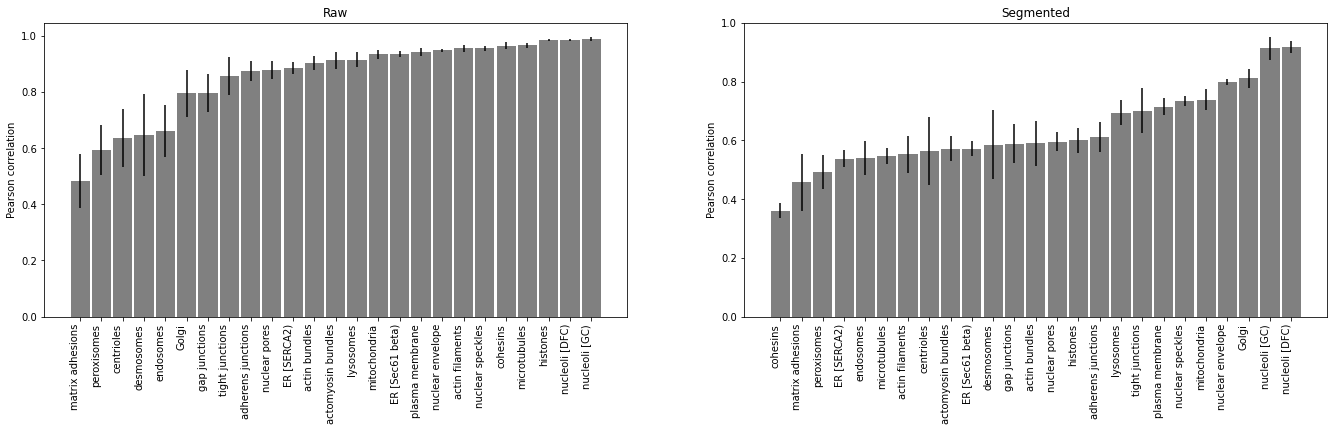

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(23,6))
fig.autofmt_xdate(rotation=90)
axs[0].set_title("Raw")
axs[0].set_ylabel("Pearson correlation")
axs[0].bar(plot_df["raw_pilr_recon_corr"].sort_values(by="mean").index, \
           plot_df["raw_pilr_recon_corr"].sort_values(by="mean")["mean"],
           yerr=plot_df["raw_pilr_recon_corr"].sort_values(by="mean")["std"],
           color="gray",
           width=0.9,
           align="center")
axs[1].set_title("Segmented")
axs[1].set_ylabel("Pearson correlation")
axs[1].bar(plot_df["seg_pilr_recon_corr"].sort_values(by="mean").index, \
           plot_df["seg_pilr_recon_corr"].sort_values(by="mean")["mean"],
           yerr=plot_df["seg_pilr_recon_corr"].sort_values(by="mean")["std"],
           color="gray",
           width=0.9,
           align="center")
fig.align_labels()
plt.show()